In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime
from sklearn.metrics import mean_absolute_error

In [3]:
data = pd.read_csv('Data/eth.csv')
data.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,31.Oct.17,307.38,310.55,305.88,305.88,"369,583,008.00","29,331,517,440.00"
1,1.Nov.17,305.76,306.40,290.58,291.69,"553,864,000.00","29,183,592,448.00"
2,2.Nov.17,290.73,293.91,281.17,287.43,"904,900,992.00","27,754,237,952.00"
3,3.Nov.17,288.50,308.31,287.69,305.71,"646,339,968.00","27,547,410,432.00"
4,4.Nov.17,305.48,305.48,295.80,300.47,"416,479,008.00","29,175,347,200.00"


In [4]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

In [5]:
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

In [6]:
def normalize_windows(data):
    normalized_data = []
    for window in data:
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalized_data.append(normalized_window)
    return np.array(normalized_data)

result = normalize_windows(result)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((283, 50, 1), (31, 50, 1))

In [7]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [10]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20,
    callbacks=[
        TensorBoard(log_dir='logs/%s' % (start_time)),
        ModelCheckpoint('./models/%s_eth.h5' % (start_time), monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
])

Train on 283 samples, validate on 31 samples
Epoch 1/20
 50/283 [====>.........................] - ETA: 5s - loss: 0.0432

/Users/parkchanjin/PycharmProjects/ml-work/venv/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.373156). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


283/283 [==============================] - 2s 8ms/step - loss: 0.0395 - val_loss: 9.2473e-04

Epoch 00001: val_loss improved from inf to 0.00092, saving model to ./models/2020_03_05_15_02_51_eth.h5
Epoch 2/20
283/283 [==============================] - 1s 5ms/step - loss: 0.0375 - val_loss: 0.0012

Epoch 00002: val_loss did not improve from 0.00092
Epoch 3/20
283/283 [==============================] - 1s 5ms/step - loss: 0.0283 - val_loss: 0.0031

Epoch 00003: val_loss did not improve from 0.00092
Epoch 4/20
283/283 [==============================] - 1s 5ms/step - loss: 0.0253 - val_loss: 0.0026

Epoch 00004: val_loss did not improve from 0.00092
Epoch 5/20
283/283 [==============================] - 2s 6ms/step - loss: 0.0231 - val_loss: 0.0017

Epoch 00005: val_loss did not improve from 0.00092
Epoch 6/20
283/283 [==============================] - 2s 6ms/step - loss: 0.0205 - val_loss: 7.3579e-04

Epoch 00006: val_loss improved from 0.00092 to 0.00074, saving model to ./models/2020_03_

# Prediction of one data ahead(not training prediction result)

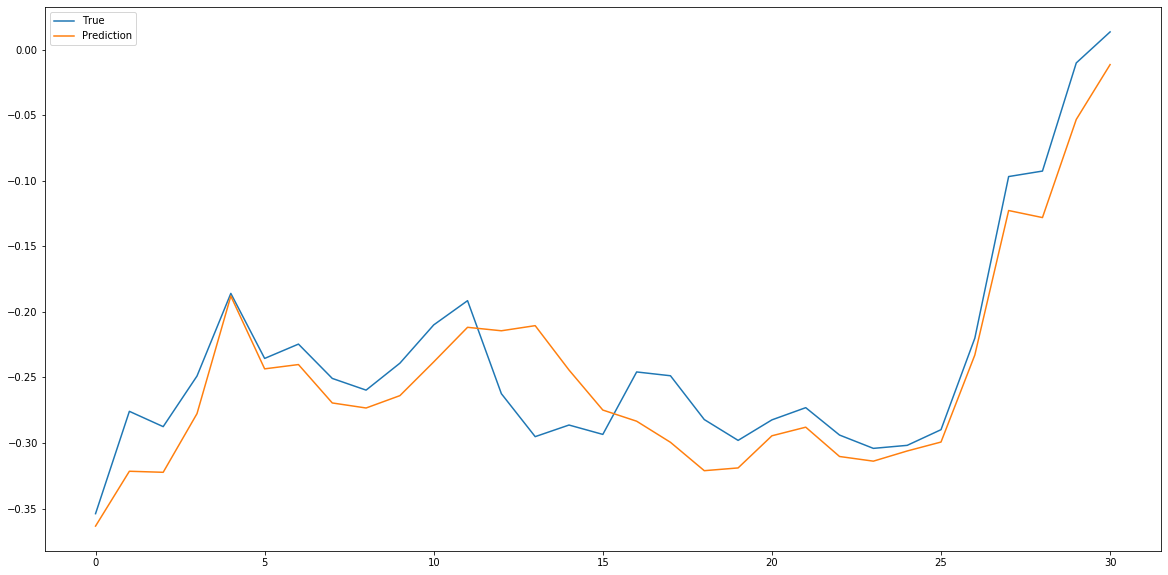

The Mean Absolute Error is: 0.02582282670107501


In [18]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()
MAE = mean_absolute_error(y_test, pred)
print('The Mean Absolute Error is: {}'.format(MAE))

# Prediction of one window ahead(training prediction result too)

In [12]:
x_train.shape

(283, 50, 1)

In [13]:
x_test[0].shape

(50, 1)

In [14]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

predictions = predict_sequence_full(model, x_test, 50)

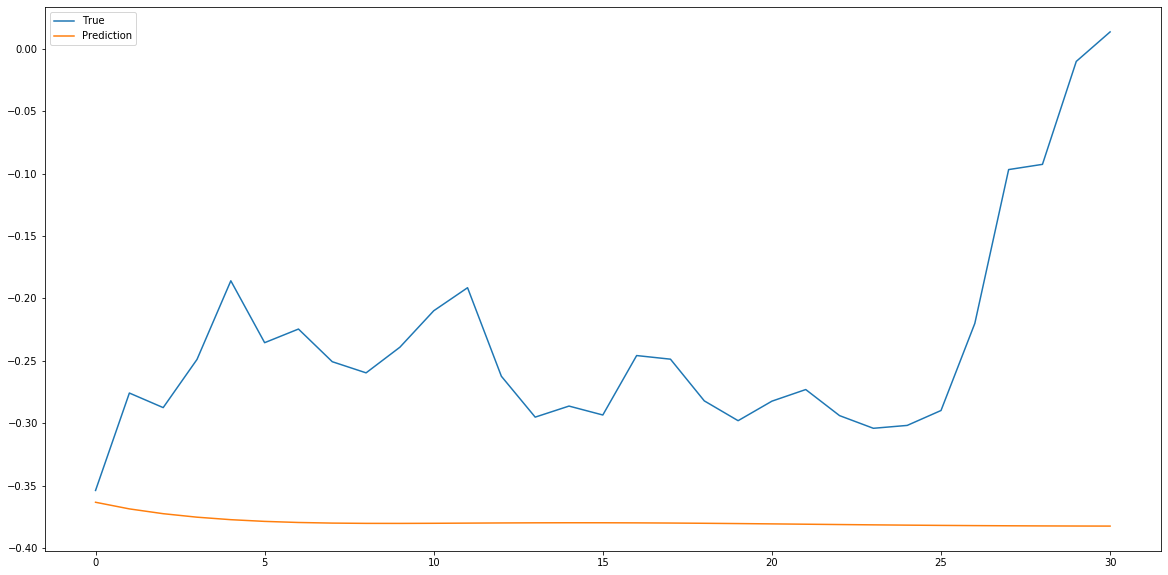

The Mean Absolute Error is: 0.14289310830254273


In [19]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(predictions, label='Prediction')
ax.legend()
plt.show()
MAE = mean_absolute_error(y_test, predictions)
print('The Mean Absolute Error is: {}'.format(MAE))

# LSTM does not solve prediction of stock price.